In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import psycopg2
DBNAME = "opportunity_youth"
conn = psycopg2.connect(dbname=DBNAME)
cursor = conn.cursor()
cursor.execute("""SELECT table_name FROM information_schema.tables
       WHERE table_schema = 'public'""")
tables = []
for table in cursor.fetchall():
    tables.append(table[0])
tables

['pums_2017',
 'puma_names_2010',
 'wa_jobs_2017',
 'wa_geo_xwalk',
 'ct_puma_xwalk']

In [4]:
df_weight = pd.read_sql("""
SELECT A.puma, sporder, serialno, sch, schl, esr, cow, agep, pwgtp
FROM pums_2017 A
JOIN puma_names_2010 B ON A.puma = B.puma
WHERE state_name LIKE 'Washington%' AND puma_name LIKE 'King County%' AND puma_name LIKE '%South%'
AND (agep BETWEEN 16.0 AND 24.9)
""", conn)
df_weight

,puma,sporder,serialno,sch,schl,esr,cow,agep,pwgtp
0,11606,01,2013000003218,3,19,1,1,21.0,14.0
1,11606,02,2013000003218,1,16,1,1,21.0,15.0
2,11612,02,2013000007063,2,18,6,None,19.0,30.0
3,11613,02,2013000008046,2,13,6,None,17.0,36.0
4,11614,02,2013000011255,2,12,6,None,17.0,13.0
...,...,...,...,...,...,...,...,...,...
2873,11606,01,2017001526134,2,18,3,1,18.0,1.0
2874,11613,01,2017001530818,1,21,1,1,23.0,26.0
2875,11606,01,2017001490932,2,16,1,1,18.0,15.0
2876,11606,01,2017001491175,2,20,6,None,19.0,1.0


In [8]:
age_count = df_weight.groupby(by='agep').sum()['pwgtp']
esr_count = df_weight.groupby(by="esr").sum()["pwgtp"]
sch_count = df_weight.groupby(by="sch").sum()["pwgtp"]

pandas.core.series.Series

In [15]:
#Function that expands the table from 2878 rows to 68347 using pwgtp
def duplicate_rows(df, countcol):
    for _, row in df.iterrows():
        for i in range(int(row[countcol])-1):
            # Append this row at the end of the DataFrame
            df = df.append(row)

    # Remove countcol (could do a drop too to do that...)
    notcountcols = [x for x in df.columns if x != countcol]
    df = df[notcountcols]
    # optional: sort it by index
    df.sort_index(inplace=True)
    return df

In [61]:
#Runs the function that duplicates the table 
df_dup = duplicate_rows(df_weight, 'pwgtp')
df_dup

,puma,sporder,serialno,sch,schl,esr,cow,agep
0,11606,01,2013000003218,3,19,1,1,21.0
0,11606,01,2013000003218,3,19,1,1,21.0
0,11606,01,2013000003218,3,19,1,1,21.0
0,11606,01,2013000003218,3,19,1,1,21.0
0,11606,01,2013000003218,3,19,1,1,21.0
...,...,...,...,...,...,...,...,...
2875,11606,01,2017001490932,2,16,1,1,18.0
2875,11606,01,2017001490932,2,16,1,1,18.0
2875,11606,01,2017001490932,2,16,1,1,18.0
2876,11606,01,2017001491175,2,20,6,None,19.0


In [156]:
#Code to add Educational Groups
def school_range (schl):
    if int(schl) < 15: return "No diploma"
    elif int(schl) < 17: return "HS diploma or GED"
    elif int(schl) < 19: return "Some College, no degree"
    elif int(schl) < 25: return "Degree (Associate or higher)"
    else: return "Unknown"
df_dup["School_Level"]= df_dup.schl.apply(school_range)
df_dup

,puma,sporder,serialno,sch,schl,esr,cow,agep,Is_OY,OY_Status,Age_Group,Total_Populations_Sch,Total_Populations,OY_Status_Counts,School_Level
0,11606,01,2013000003218,3,19.0,1,1,21.0,Not Opportunity Youth,Working without Diploma,19-21,20710.0,20710.0,35374,Degree (Associate or higher)
0,11606,01,2013000003218,3,19.0,1,1,21.0,Not Opportunity Youth,Working without Diploma,19-21,20710.0,20710.0,35374,Degree (Associate or higher)
0,11606,01,2013000003218,3,19.0,1,1,21.0,Not Opportunity Youth,Working without Diploma,19-21,20710.0,20710.0,35374,Degree (Associate or higher)
0,11606,01,2013000003218,3,19.0,1,1,21.0,Not Opportunity Youth,Working without Diploma,19-21,20710.0,20710.0,35374,Degree (Associate or higher)
0,11606,01,2013000003218,3,19.0,1,1,21.0,Not Opportunity Youth,Working without Diploma,19-21,20710.0,20710.0,35374,Degree (Associate or higher)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2875,11606,01,2017001490932,2,16.0,1,1,18.0,Not Opportunity Youth,Working without Diploma,16-18,16310.0,16310.0,35374,HS diploma or GED
2875,11606,01,2017001490932,2,16.0,1,1,18.0,Not Opportunity Youth,Working without Diploma,16-18,16310.0,16310.0,35374,HS diploma or GED
2875,11606,01,2017001490932,2,16.0,1,1,18.0,Not Opportunity Youth,Working without Diploma,16-18,16310.0,16310.0,35374,HS diploma or GED
2876,11606,01,2017001491175,2,20.0,6,None,19.0,Not Opportunity Youth,Not Opportunity Youth,19-21,20710.0,20710.0,25528,Degree (Associate or higher)


In [137]:
def Y_Status (esr, sch):
    if (int(esr) == 3 or int(esr) == 6) and int(sch) == 1: return "Opportunity Youth"
    else: return "Not Opportunity Youth"
df_dup["Is_OY"] = df_dup.apply(lambda x: Y_Status(x["esr"], x["sch"]), axis=1)

In [138]:
#Code to add OY_Status, for pivot grouping
def Y_Status (esr, sch):
    if (int(esr) == 3 or int(esr) == 6) and int(sch) == 1: return "Opportunity Youth"
    elif (int(esr) == 1 or int(esr) == 2 or int(esr) == 4 or int(esr) == 5) and int(sch) <= 15: return "Working without Diploma"
    else: return "Not Opportunity Youth"
df_dup["OY_Status"] = df_dup.apply(lambda x: Y_Status(x["esr"], x["sch"]), axis=1)

In [139]:
#Code that adds Age_Group and groups ages into bins
df_dup['Age_Group'] = pd.cut(x=df_dup['agep'], bins=[16, 18, 21, 24], labels=['16-18', '19-21', '21-24'])

In [140]:
#Groups OY_Status
puma_df_piv.groupby("OY_Status").count()

,puma,sporder,serialno,sch,schl,esr,cow,agep,pwgtp,Age_Group
OY_Status,,,,,,,,,,
Not Opportunity Youth,1158,1158,1158,1158,1158,1158,390,1158,1158,817
Opportunity Youth,307,307,307,307,307,307,199,307,307,294
Working without Diploma,1413,1413,1413,1413,1413,1413,1413,1413,1413,1365


In [141]:
#adds Total_Population_School for the second pivot
df_dup2 = df_dup
df_dup2 = df_dup2.reset_index()

In [146]:
df_dup2

,puma,sporder,serialno,sch,schl,esr,cow,agep,Is_OY,OY_Status,Age_Group,Total_Populations_Sch,Total_Populations,OY_Status_Counts
0,11606,01,2013000003218,3,19,1,1,21.0,Not Opportunity Youth,Working without Diploma,19-21,20710.0,20710.0,35374
0,11606,01,2013000003218,3,19,1,1,21.0,Not Opportunity Youth,Working without Diploma,19-21,20710.0,20710.0,35374
0,11606,01,2013000003218,3,19,1,1,21.0,Not Opportunity Youth,Working without Diploma,19-21,20710.0,20710.0,35374
0,11606,01,2013000003218,3,19,1,1,21.0,Not Opportunity Youth,Working without Diploma,19-21,20710.0,20710.0,35374
0,11606,01,2013000003218,3,19,1,1,21.0,Not Opportunity Youth,Working without Diploma,19-21,20710.0,20710.0,35374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2875,11606,01,2017001490932,2,16,1,1,18.0,Not Opportunity Youth,Working without Diploma,16-18,16310.0,16310.0,35374
2875,11606,01,2017001490932,2,16,1,1,18.0,Not Opportunity Youth,Working without Diploma,16-18,16310.0,16310.0,35374
2875,11606,01,2017001490932,2,16,1,1,18.0,Not Opportunity Youth,Working without Diploma,16-18,16310.0,16310.0,35374
2876,11606,01,2017001491175,2,20,6,None,19.0,Not Opportunity Youth,Not Opportunity Youth,19-21,20710.0,20710.0,25528


In [226]:
#Sets up a new dataframe to draw our graphs drom
df_chart = df_dup
df_chart['schl'] = df_chart['schl'].astype(float)
#
#Creates a dataframe of df_dup2 that is only Opportunity Youth
oy_chart = df_dup.loc[df_dup2["Is_OY"] == "Opportunity Youth"]
#Creates a dataframe of df_dp2 that is everyone not an Opportunity You
noy_chart = df_dup.loc[df_dup2["Is_OY"] == "Not Opportunity Youth"]

In [142]:
#adds Total_Population_School for the second pivot
df_dup2 = df_dup
df_dup2["Total_Populations_Sch"]=df_dup2.groupby("Age_Group")["Age_Group"].transform("count")
#adds Total_Population column that takes the total population of each age group
df_dup2["Total_Populations"]=df_dup2.groupby("Age_Group")["Age_Group"].transform("count")
df_dup2["OY_Status_Counts"]=df_dup2.groupby("OY_Status")["OY_Status"].transform("count")

In [157]:
df_dup2.groupby("School_Level").count()

,puma,sporder,serialno,sch,schl,esr,cow,agep,Is_OY,OY_Status,Age_Group,Total_Populations_Sch,Total_Populations,OY_Status_Counts
School_Level,,,,,,,,,,,,,,
Degree (Associate or higher),19902,19902,19902,19902,19902,19902,17540,19902,19902,19902,19902,19902,19902,19902
HS diploma or GED,18882,18882,18882,18882,18882,18882,15767,18882,18882,18882,18805,18805,18805,18882
No diploma,22374,22374,22374,22374,22374,22374,8721,22374,22374,22374,14135,14135,14135,22374
"Some College, no degree",7279,7279,7279,7279,7279,7279,6235,7279,7279,7279,7165,7165,7165,7279


In [144]:
df_dup2.groupby("Age_Group").count()

,puma,sporder,serialno,sch,schl,esr,cow,agep,Is_OY,OY_Status,Total_Populations_Sch,Total_Populations,OY_Status_Counts
Age_Group,,,,,,,,,,,,,
16-18,16310,16310,16310,16310,16310,16310,8368,16310,16310,16310,16310,16310,16310
19-21,20710,20710,20710,20710,20710,20710,16761,20710,20710,20710,20710,20710,20710
21-24,22987,22987,22987,22987,22987,22987,21303,22987,22987,22987,22987,22987,22987


PIVOT TABLE CODE - School Level

In [227]:
oy_chart.sort_values(["School_Level"])
grouper = oy_chart.groupby(["Age_Group", "School_Level"])["Total_Populations_Sch"].count()
grouper = oy_chart.groupby(["Age_Group", "School_Level"], as_index=False).count()

In [228]:
#Creates School Level Pivot
sch_piv=grouper.pivot(index="School_Level", columns="Age_Group", values="Total_Populations")
sch_piv

Age_Group,16-18,19-21,21-24
School_Level,,,
Degree (Associate or higher),19,341,812
HS diploma or GED,621,1737,1461
No diploma,464,560,531
"Some College, no degree",13,131,567


PIVOT TABEL CODE - Opportunity Youth

In [58]:
df_dup2.sort_values(["Age_Group"])
grouper_oy = df_dup2.groupby(["Age_Group", "OY_Status"])["Total_Populations"].count()
grouper_oy = df_dup2.groupby(["Age_Group", "OY_Status"], as_index=False).count()

Age_Group  OY_Status              
16-18      Not Opportunity Youth      10298
           Opportunity Youth           1117
           Working without Diploma     4895
19-21      Not Opportunity Youth       5592
           Opportunity Youth           2769
           Working without Diploma    12349
21-24      Not Opportunity Youth       2363
           Opportunity Youth           3371
           Working without Diploma    17253
Name: Total_Populations, dtype: int64
  Age_Group                OY_Status  index   puma  sporder  serialno    sch  \
0     16-18    Not Opportunity Youth  10298  10298    10298     10298  10298   
1     16-18        Opportunity Youth   1117   1117     1117      1117   1117   
2     16-18  Working without Diploma   4895   4895     4895      4895   4895   
3     19-21    Not Opportunity Youth   5592   5592     5592      5592   5592   
4     19-21        Opportunity Youth   2769   2769     2769      2769   2769   
5     19-21  Working without Diploma  12349  12349 

In [65]:
#Creates OY_Status Pivot Table
oy_piv=grouper_oy.pivot(index="OY_Status", columns="Age_Group", values="Total_Populations")
oy_piv

Age_Group,16-18,19-21,21-24
OY_Status,,,
Not Opportunity Youth,10298,5592,2363
Opportunity Youth,1117,2769,3371
Working without Diploma,4895,12349,17253


CODE BELLOW IS FOR GRAPHS

In [149]:
#Sets up a new dataframe to draw our graphs drom
df_chart = df_dup2
df_chart['schl'] = df_chart['schl'].astype(float)
#
#Creates a dataframe of df_dup2 that is only Opportunity Youth
oy_chart = df_dup2.loc[df_dup2["Is_OY"] == "Opportunity Youth"]
#Creates a dataframe of df_dp2 that is everyone not an Opportunity You
noy_chart = df_dup2.loc[df_dup2["Is_OY"] == "Not Opportunity Youth"]

0.6322106141230123
3.6587510631141167


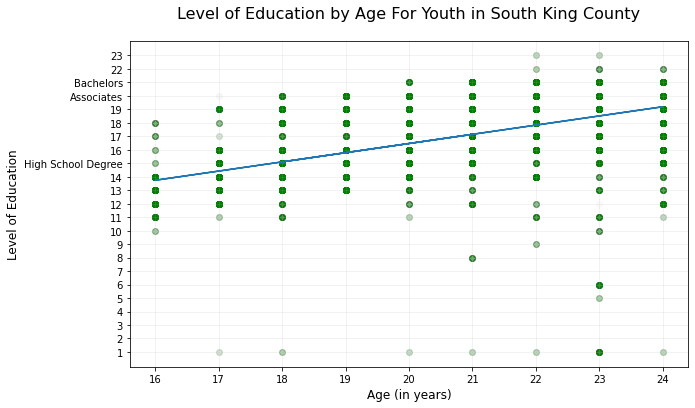

In [221]:
#Builds, labels, titles, the scatter
fig, ax = plt.subplots(figsize=(10, 6))
ax_scatter = plt.scatter(df_dup2.agep, df_dup2.schl, alpha=.01, c='green')
plt.title('Level of Education by Age For Youth in South King County', fontsize=16, y=1.05)
plt.xlabel('Age (in years)', fontsize=12)
plt.ylabel('Level of Education', fontsize=12)
plt.yticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 'High School Degree',16, 17, 18, 19, 'Associates', 'Bachelors', 22, 23])
plt.grid(alpha=.2)

#best fit line
plt.plot(noy_chart.agep, np.poly1d(np.polyfit(noy_chart.agep, noy_chart.schl, 1))(noy_chart.agep))

#Finding best fit M and B
acx = df_dup2.agep
acy = df_dup2.schl
acy.to_numpy(dtype="float32")
acx.to_numpy(dtype="float32")
m, b = np.polyfit(acx, acy, 1)

#Saves Graph
plt.savefig('project_one_scatter_all.png', dpi=300, bbox_inches='tight')

#Prints m, then b, then plots the graph
print(m)
print(b)
plt.show()

0.6814773840095679
2.8379791408551482


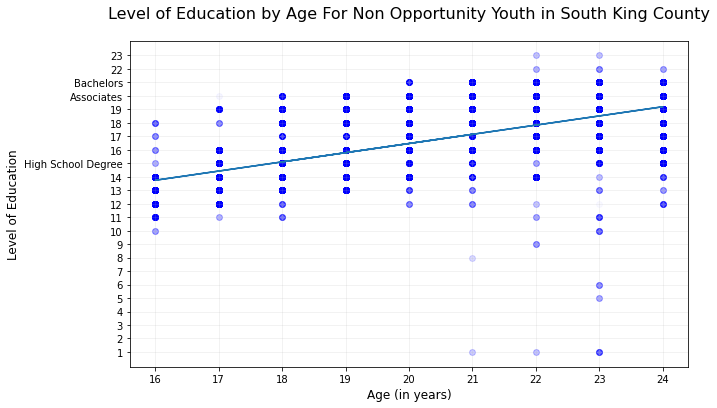

In [222]:
#Builds, labels, titles, the scatter
fig, ax = plt.subplots(figsize=(10, 6))
ax_scatter = plt.scatter(noy_chart.agep, noy_chart.schl, alpha=.01, c='blue')
plt.title('Level of Education by Age For Non Opportunity Youth in South King County', fontsize=16, y=1.05)
plt.xlabel('Age (in years)', fontsize=12)
plt.ylabel('Level of Education', fontsize=12)
plt.yticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 'High School Degree',16, 17, 18, 19, 'Associates', 'Bachelors', 22, 23])
plt.grid(alpha=.2)

#best fit line
plt.plot(noy_chart.agep, np.poly1d(np.polyfit(noy_chart.agep, noy_chart.schl, 1))(noy_chart.agep))

#Finding best fit M and B
ncx = noy_chart.agep
ncy = noy_chart.schl
ncy.to_numpy(dtype="float32")
ncx.to_numpy(dtype="float32")
m, b = np.polyfit(ncx, ncy, 1)

#Saves graph
plt.savefig('project_one_scatter_noy.png', dpi=300, bbox_inches='tight')

#Prints m, then b, then plots the graph
print(m)
print(b)
plt.show()

0.3255958473778856
8.78762249272257


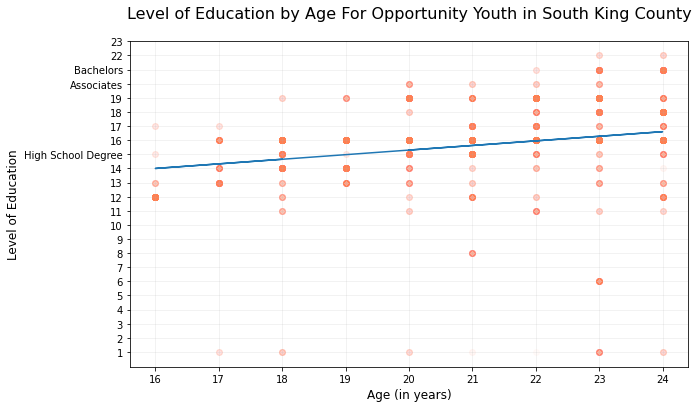

In [229]:
#Builds, labels, titles, the scatter
fig, ax = plt.subplots(figsize=(10, 6))
ax_scatter = plt.scatter(oy_chart.agep, oy_chart.schl, alpha=.01, c="coral")
plt.title('Level of Education by Age For Opportunity Youth in South King County', fontsize=16, y=1.05)
plt.xlabel('Age (in years)', fontsize=12)
plt.ylabel('Level of Education', fontsize=12)
plt.yticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 'High School Degree',16, 17, 18, 19, 'Associates', 'Bachelors', 22, 23])
plt.grid(alpha=.2)

#Best fit line
plt.plot(oy_chart.agep, np.poly1d(np.polyfit(oy_chart.agep, oy_chart.schl, 1))(oy_chart.agep))
#Finding best fit M and B
ocx = oy_chart.agep
ocy = oy_chart.schl
ocy.to_numpy(dtype="float32")
ocx.to_numpy(dtype="float32")
m, b = np.polyfit(ocx, ocy, 1)

#Saves Graph
plt.savefig('project_one_scatter_oy.png', dpi=300, bbox_inches='tight')

#Prints m, then b, then plots the graph
print(m)
print(b)
plt.show()

In [224]:
oy_chart

,puma,sporder,serialno,sch,schl,esr,cow,agep,Is_OY,OY_Status,Age_Group,Total_Populations_Sch,Total_Populations,OY_Status_Counts
16,11615,04,2013000047506,1,16.0,6,None,20.0,Opportunity Youth,Opportunity Youth,19-21,20710.0,20710.0,7535
16,11615,04,2013000047506,1,16.0,6,None,20.0,Opportunity Youth,Opportunity Youth,19-21,20710.0,20710.0,7535
16,11615,04,2013000047506,1,16.0,6,None,20.0,Opportunity Youth,Opportunity Youth,19-21,20710.0,20710.0,7535
16,11615,04,2013000047506,1,16.0,6,None,20.0,Opportunity Youth,Opportunity Youth,19-21,20710.0,20710.0,7535
16,11615,04,2013000047506,1,16.0,6,None,20.0,Opportunity Youth,Opportunity Youth,19-21,20710.0,20710.0,7535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2872,11613,01,2017001518359,1,11.0,6,1,18.0,Opportunity Youth,Opportunity Youth,16-18,16310.0,16310.0,7535
2872,11613,01,2017001518359,1,11.0,6,1,18.0,Opportunity Youth,Opportunity Youth,16-18,16310.0,16310.0,7535
2872,11613,01,2017001518359,1,11.0,6,1,18.0,Opportunity Youth,Opportunity Youth,16-18,16310.0,16310.0,7535
2872,11613,01,2017001518359,1,11.0,6,1,18.0,Opportunity Youth,Opportunity Youth,16-18,16310.0,16310.0,7535
